In [68]:
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.linalg import eigh
import numpy as np
from scipy.ndimage import gaussian_filter
import math
from numpy import linalg as LA

In [69]:
imsize = 400

# Load and resize the content image
content = cv2.imread("./images/house 2-small.jpg")
content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0


content_copy = content.copy()
content = content[0:imsize, 0:imsize]

# Load and resize the style image
style = cv2.imread("./images/starry-night - small.jpg")
style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
style = style[0:imsize, 0:imsize]

(-0.5, 399.5, 399.5, -0.5)

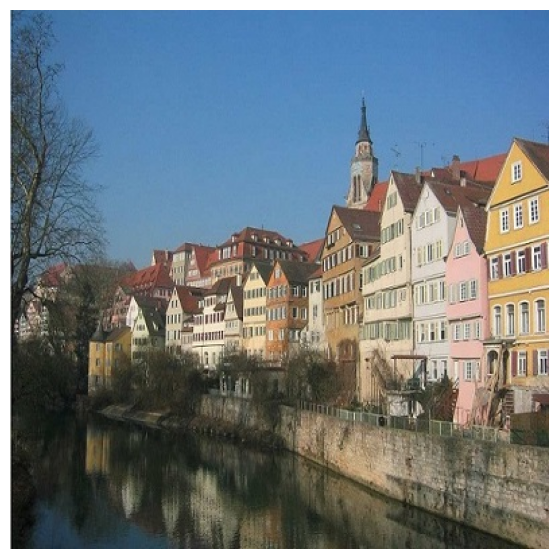

In [70]:
plt.figure(figsize=(15,7))
plt.imshow(content)
plt.axis("off")

(-0.5, 399.5, 399.5, -0.5)

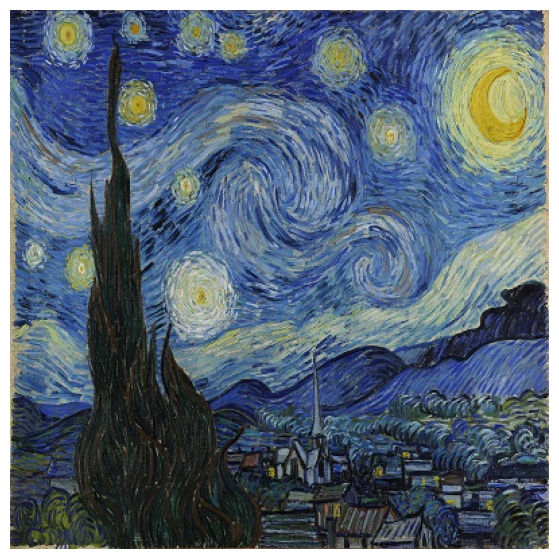

In [71]:
plt.figure(figsize=(15,7))
plt.imshow(style)
plt.axis("off")

In [72]:
import math

## -------------------------------MATLAB -----------------

# elseif opt == 1
   
#     RXp = Vp.T * (RX-mp);
#     dif = repmat(RXp, [1 size(Pp,2)]) - Pp;
#     sqr = sum(dif.^2, 1);
#     sqr = sqr+0.1*min(sqr)*randn(size(sqr)); % add some noise to NN 
#     [~, idx] = min(sqr);
# %     ls = mod(idx-1, (w-Q_size+1)) + 1;
# %     ks = floor((idx-1)/(w-Q_size+1)) + 1;
#     [ls,ks]=ind2sub([(floor( ((w-Q_size+1)-1)/Pstride ) + 1) (floor( ((h-Q_size+1)-1)/Pstride ) + 1 )],ceil(idx/4)); %flipped since ind goes across rows, then down columns 
#     ks=(ks-1)*Pstride+1;
#     ls=(ls-1)*Pstride+1;
#     ang=mod(idx+3,4); %+3 to match ang=90*(0:3)


# z = S(ks:ks+Q_size-1,ls:ls+Q_size-1,:); %maybe compute outside so no need to pass S
# % z = edge_smooth(z, gap);

# z = z(:);

def nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap):
  
    S = S.reshape((h, w, c))
    RX = X[R==1]
    RXp = np.dot(Vp.T, (RX - mp))

        # RX Shape  (3888,)
        # mp shape (3888,)
        # Pp shape  (802, 33856)
        # Vp.T shape  (802, 3888)
        # Rxp shape  (802,)
        # RXp shape: (802,)
        # Pp shape: (802, 33856)

    dif = np.tile(RXp[:, np.newaxis], (1, Pp.shape[1])) - Pp
    # print("dif",dif.shape)

    sqr = np.sum(dif**2, axis=0)
    sqr = sqr + 0.1 * np.min(sqr) * np.random.randn(sqr.size)

    # sqr = sqr + 0.1 * np.min(sqr) * np.random.randn(sqr.shape[0])  # Add some noise to 'sqr'
    idx = np.argmin(sqr)
    # print("sqr: ", sqr.shape)

    # ks  is row, ls is column
    ks, ls = np.unravel_index(idx//4, ((w-Q_size+1-1)//Pstride+1, (h-Q_size+1-1)//Pstride+1)) #flipped since ind goes across rows, then down columns
    
    # print("ks: ", ks, "ls: ", ls)
    
    ks = (ks)*Pstride
    ls = (ls)*Pstride

    ks_start, ks_end = max(ks, 0), min(ks+Q_size, h)
    ls_start, ls_end = max(ls, 0), min(ls+Q_size, w)
  
    ang = (idx+3)%4 
    #+3 to match ang=90*(0:3)
    # Equivalent to mod(idx + 3, 4)
   
    # z = S[ks-1:ks+Q_size-1, ls-1:ls+Q_size-1,:] #maybe compute outside so no need to pass S
    # print("ks start: ", ks_start, "ks end: ", ks_end)
    # print("ls start: ", ls_start, "ls_end: ", ls_end)
    z = S[ks_start:ks_end, ls_start:ls_end, :]
    z = z.reshape(-1)
    # print(z.shape)
    return ks, ls, z, ang
    # return 2


In [73]:

            #w=sum(
            # (Xk(logical(R(:,i)))-z(:,i)).^2 
            # 
            # + 1e-10
            # ).
            # 
            # 
            # 
            # ^((r-2)/2);

In [74]:
def irls(R, X, z):
    tNc, Nij = R.shape
    I = 1  # Max number of IRLS iterations
    Xk = X  # Current estimate

    r = 0.8
    value = np.sum(R, axis=1)
    logical_array = value > 0
    # print(logical_array.shape)
    
    unsampled_pixs = np.double(~logical_array)  # Prevent black bar artifacts from gap

    for k in range(I):
        A = unsampled_pixs  # Prevent black bar artifacts from gap
        B = Xk * unsampled_pixs

        for i in range(Nij):
            tm = Xk[R[:,i] == 1]
            diff = tm - z[:,i]
            new_diff = diff**2
            c = 1e-10
            new_diff = np.add(new_diff,c)
            w = np.sum(new_diff)
            w=w**((r-2)/2)

            A = A + w * R[:, i]
            temp = R[:,i]
            temp[temp==1] = z[:,i]
            B = B + w * temp

        A = np.add(A, 1e-10)
        Xk = (1 / (A)) * B
    
    return Xk

In [75]:
# Sample 2D array
R = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# Calculate the sum along the second dimension (columns) of the array R
sum_R = np.sum(R, axis=1)

# Create a boolean array by checking if each element in the 1D sum array is greater than 0
logical_array = sum_R > 0

# Invert the boolean array and convert to double
unsampled_pixs = np.double(~logical_array)

# Display the array and results
print('sum_R:')
print(sum_R)

print('logical_array:')
print(logical_array)

print('unsampled_pixs:')
print(unsampled_pixs)

sum_R:
[ 6 15 24]
logical_array:
[ True  True  True]
unsampled_pixs:
[0. 0. 0.]


In [76]:
import numpy as np

# Define the Recursive Filter function
def RF(img, sigma_s, sigma_r, num_iterations=3, joint_image=None):
    I = np.double(img)

    if joint_image is not None:
        J = np.double(joint_image)

        if I.shape[:2] != J.shape[:2]:
            raise ValueError('Input and joint images must have equal width and height.')
    else:
        J = I
    
    h, w, num_joint_channels = J.shape
    
    # Compute the domain transform
    dIcdx = np.diff(J, axis=1)
    dIcdy = np.diff(J, axis=0)
    
    dIdx = np.zeros((h, w))
    dIdy = np.zeros((h, w))
    
    for c in range(num_joint_channels):
        dIdx[:, 1:] += np.abs(dIcdx[:, :, c])
        dIdy[1:, :] += np.abs(dIcdy[:, :, c])
     
    dHdx = (1 + sigma_s / sigma_r * dIdx)
    dVdy = (1 + sigma_s / sigma_r * dIdy)
     
    dVdy = dVdy.T
    
    # Perform the filtering
    N = num_iterations
    F = I.copy()
    sigma_H = sigma_s

    for i in range(num_iterations):
        sigma_H_i = sigma_H * np.sqrt(3) * 2**(N - (i + 1)) / np.sqrt(4**N - 1)

        F = TransformedDomainRecursiveFilter_Horizontal(F, dHdx, sigma_H_i)
        F = image_transpose(F)

        F = TransformedDomainRecursiveFilter_Horizontal(F, dVdy, sigma_H_i)
        F = image_transpose(F)

    return F.astype(img.dtype)

def TransformedDomainRecursiveFilter_Horizontal(I, D, sigma):
    a = np.exp(-np.sqrt(2) / sigma)
    F = I.copy()
    V = a**D

    h, w, num_channels = I.shape

    for i in range(1, w):
        for c in range(num_channels):
            F[:, i, c] += V[:, i] * (F[:, i - 1, c] - F[:, i, c])

    for i in range(w-2, -1, -1):
        for c in range(num_channels):
            F[:, i, c] += V[:, i + 1] * (F[:, i + 1, c] - F[:, i, c])

    return F
     
def image_transpose(I):
    h, w, num_channels = I.shape
    T = np.zeros((w, h, num_channels), dtype=I.dtype)

    for c in range(num_channels):
        T[:, :, c] = I[:, :, c].T

    return T


In [77]:

def style_transfer(content, style, hall, mask0, hallcoeff, Wcoeff, patch_sizes, scales, imsize):
    
    gap_sizes=[28 ,18 , 9, 6]
   
    # Smoothening the content image
    # C0 = cv2.GaussianBlur(content, (5, 5), 100)
    C0 = cv2.GaussianBlur(content, ksize=(0, 0), sigmaX=100, borderType=cv2.BORDER_REPLICATE)
    

    # 2d image into 1d array
    C0 = C0.reshape(-1)
    S0 = style.reshape(-1)

    h0 = imsize
    w0 = imsize
    # number of channels
    c = 3
    
    # Convert to 3D arrays only to use in histogram matching of color
    C0 = C0.reshape(h0, w0, c)
    S0 = S0.reshape(h0, w0, c)

    sigma_s = 5
    sigma_r = 0.2
     
    for channel in range(c):
        C0[:, :, channel] = exposure.match_histograms(C0[:, :, channel], S0[:, :, channel])
        

    C0 = C0.reshape(-1)
    X = C0

    # INITIALISING OUTPUT IMAGE WITH NOISE - this is done to prevent repetitive patches 

    X = X + np.max(X) * np.random.randn(X.size)
    X = X.reshape(h0, w0, c)
    X = X.reshape(-1)
    
    # Looping over scale sizes

    for L in scales:

        # here we first reshape into 3d array then scale down by factor of L. (0,0) is specified to determine size of output image 
        # It implies OpenCV should automatically calculate the size of the output image based on the provided scaling factors fx and fy

        C_scaled = cv2.resize(C0.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)
        S_scaled = cv2.resize(S0.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)

        # mask0 was the 400 x 400 array of 1s. We resize that as well

        mask = cv2.resize(mask0, (0,0), fx=1/L, fy=1/L)
        C = C_scaled.reshape(-1)
        S = S_scaled.reshape(-1)
        
        h = np.ceil(h0/L).astype(int)
        w = np.ceil(w0/L).astype(int)
      
        X = cv2.resize(X.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)

        # Halls is 400 x 400 x 3 array of 1s 
        halls = cv2.resize(hall, (0,0), fx=1/L, fy=1/L)

        X = X.reshape(-1)
        # print(X.shape)   # shape here is 30,000

    
        for n in patch_sizes:

            Q_size = n
            
            # PRECOMPUTE P

            Pstride = 4

            S = S.reshape((h, w, c))

           

            numpatches =(int(((h - Q_size + 1) - 1) / Pstride) + 1) * (int(((w - Q_size + 1) - 1) / Pstride) + 1) 
            numpatches = numpatches * 4  # this is for all four rotations

            P = np.zeros((c * Q_size * Q_size, numpatches))

        

            for k in range(0, h - Q_size + 1, Pstride):
                for j in range(0, w - Q_size + 1, Pstride):

                    # extracting current patch
                    patch = S[k:k+Q_size, j:j+Q_size, :]

                    # Compare for each of the 4 orientations
                    for l in range(4):
                        temp = np.rot90(patch,l)
                        P[:, (int(k / Pstride)) * (int((w - Q_size + 1 - 1) / Pstride) + 1) * 4 + (int(j / Pstride)) * 4 + l] = temp.flatten()
      
            S = S.reshape(-1)
            mp = np.mean(P, axis=1)

           
            result_matrix = mp.reshape(-1, 1)
          
            num_cols = P.shape[1]
            expanded_means = np.repeat(result_matrix, num_cols, axis=1)

            # replicating mp dimension of P times and substracting from P
            P = P - expanded_means

            CoP = np.dot(P, P.T)
        

            D, V = np.linalg.eigh(CoP)
            sorted_indices = np.argsort(D)[::-1]
            
            D_sorted = D[sorted_indices]
            V_sorted = V[:, sorted_indices]
         
            eig_idx = 0
            energy = 0
            
            # To store cumulative energy
            total_energy = sum(D_sorted)

            for i in range(len(D_sorted)):
                energy += D_sorted[i]
                if energy >= 0.95 * total_energy:
                    eig_idx = i
                    break
            
            # Retain only upto eig_idx number of eiegnvectors

            Vp = V_sorted[:, :eig_idx+1]

        
            Pp = np.dot(Vp.T, P) 
        
            
            #     --------------------------------------------------CORRECT TILL HERE---------------------------------------
           
            # Iterate for k=1, ..., Ialg
            for k in range(1):
                
                # 1. Style Fusion
                X = hallcoeff * halls.reshape(-1) + (1 - hallcoeff) * X.reshape(-1)
                # X = X.reshape(h0, w0, c)
                # plt.figure(figsize=(5,5))
                # plt.imshow(X)
                # plt.axis("off")              
                
                # 2. Patch Matching
                gap = next(gap for gap, size in zip(gap_sizes, patch_sizes) if size == n)
                num_patch = (math.floor(((h - Q_size + 1) - 1) / gap) + 1) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1)
                Rall = np.zeros((h * w * c, num_patch))
                z = np.zeros((c * n**2, num_patch))
                
                for i in range(0, h-Q_size+1, gap):
                    for j in range(0, w-Q_size+1, gap):
                        R = np.zeros((h, w, c))

                        R[i:i+Q_size, j:j+Q_size, :] = 1
                        R = R.reshape(-1)

                        
                        Rall[:, (math.ceil(i / gap) ) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1) + math.ceil(j / gap)] = R

                        ks, ls, zij, ang = nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap)
                        # print("zij: ", zij.shape)
                        new_z = zij.reshape((n,n,c))
                        # print(new_z.shape)32
                        temp = np.rot90(zij.reshape((n, n, c)), int(ang), axes=(0, 1))
                    
                        z[:, (math.ceil(i / gap) ) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1) + math.ceil(j / gap)]=temp.reshape(-1)

                # 3. Style Synthesis
                print('robust aggregation')
                Xtilde = irls(Rall, X, z)
                # Xtilde = Xtilde.reshape(h,w,c)
                # return Xtilde

                # return X
                # 4. Content Fusion
                print('content fusion')
                
                # W = np.tile(Wcoeff * mask.ravel() / np.max(mask), c)
                # Xhat = (1 / (W + np.ones_like(W))) * (Xtilde + W * C)
                # W = repmat(Wcoeff*mask(:)/max(mask(:)),c,1);
                num_cols = c
                flat_mask = mask.flatten()
                flat_mask = flat_mask / np.max(flat_mask)
                replicated_matrix = Wcoeff * flat_mask
                W = np.repeat(replicated_matrix, num_cols, axis=0)
                
                # Xhat=(1./(W+ones(size(W)))).   *   (Xtilde+W.*C);   % W is (3*Nc/L x 1)
                new_one = np.ones(W.shape)
                new_one = new_one + W
                new_one = 1/new_one
                second_mat = Xtilde + W*C
                Xhat = new_one * second_mat

                # 5. Color Transfer
                print('color transfer')
                Xhat = Xhat.reshape(h, w, c)
                S = S.reshape(h, w, c)
                X = X.reshape(h,w,c)

                # Initialize C to color palette of S using histogram matching
                for channel in range(c):
                    X[:, :, channel] = exposure.match_histograms(Xhat[:, :, channel], S[:, :, channel])
                
            #    Denoise here

    if L > 1:
        X = np.reshape(X, (h, w, c))
        X = cv2.resize(X, None, fx=L, fy=L, interpolation=cv2.INTER_LINEAR)
        X = X.flatten()

    
    X = X.reshape((imsize, imsize, 3))
    return X
             

In [78]:
import numpy as np
from skimage import filters, segmentation
from skimage.filters import gaussian
from skimage.feature import canny
import cv2

def segment(C, scale):
    gray=cv2.cvtColor(C, cv2.COLOR_RGB2GRAY)
    sigma_edge = scale * 1
    sigma_blur = scale * 7

    # Convert color image to grayscale
    gray_C = cv2.cvtColor(C, cv2.COLOR_RGB2GRAY)

    # Apply Canny edge detection to grayscale image
    E = canny(gray_C, sigma=sigma_edge)

    # Apply Gaussian blur
    B = gaussian(0.5 * E, sigma=sigma_blur)

    # Create a mask
    mask = B > np.mean(B)

    # Convert the mask to uint8
    # Assuming segmentation.active_contour is the same as in your previous code
    # Make sure to provide the correct parameters for active_contour
    BW = segmentation.active_contour(B, mask)

    # Convert BW to float and resize it to match the shape of E
    BW = BW[:, 0].astype(float)  # Adjust the index based on your data structure

    # Resize BW to match the shape of E
    BW = np.resize(BW, E.shape)

    W = gaussian((BW + 10 * E).astype(float), sigma=sigma_blur)

    return W


(400, 400)


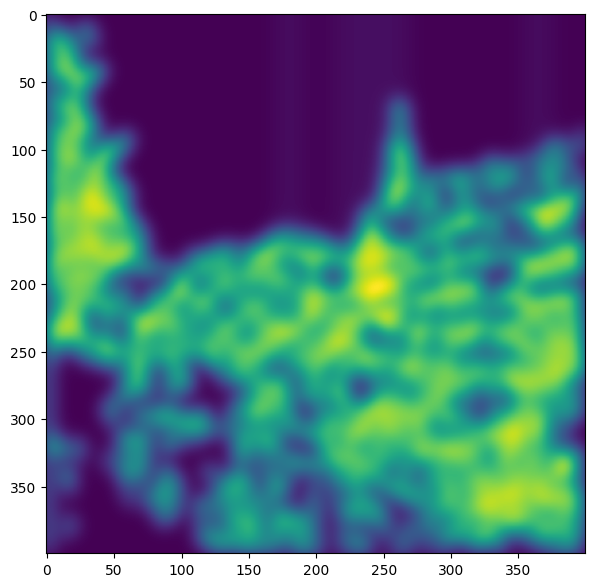

In [79]:
# call segment function
W= segment(content, 1)
# convert to gray
# print W size
print(W.shape)
plt.figure(figsize=(15,7))
plt.imshow(W)

robust aggregation
content fusion
color transfer
hall shape:  (400, 400, 3)
robust aggregation
content fusion
color transfer


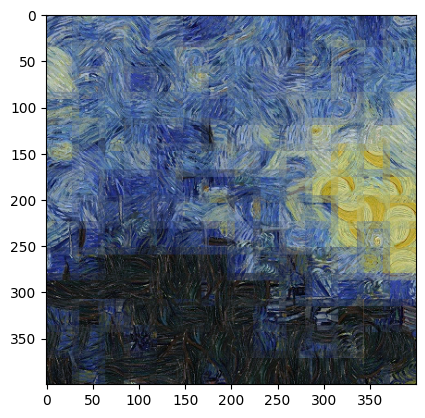

In [80]:
imsize = 400  

hall = style_transfer(
    content,
    style,
    np.ones((400, 400, 3)),
    np.ones((400, 400)),
    0,
    0,
    [36],
    [1],
    imsize
)

print("hall shape: ", hall.shape)

est_img=style_transfer(
    content,
    style,
    hall,
    segment((content), 1),
    0.25,
    1.5,
    [36],
    [4],
    imsize
)

plt.imshow(est_img)


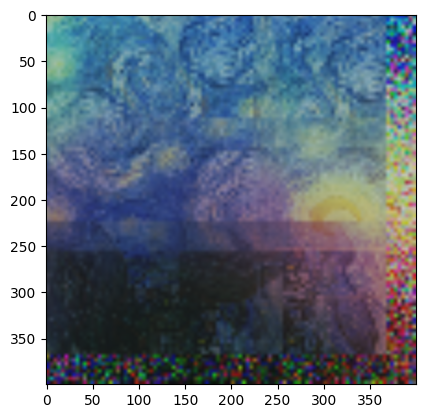

In [81]:
plt.imshow(est_img)
